<a href="https://colab.research.google.com/github/jakazaplotnik/Nematic-elastic-constants/blob/main/elastic_constants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural networks determination of nematic elastic constants** 

This notebook is a collection of Python functions that are used in a method for determination of nematic elastic constants, which is described in *\[J. Zaplotnik, M. Škarabot, M. Ravnik. Neural networks determination of material parameters and structures in nematic complex fluids, submitted in 2022\]*.
Running all the following notebook cells below one after another, you will create a training data set (you will generate hundreds of random initial states of liquid crystal samples with random elastic constants, numerically simulate the liquid crystal dynamics and light transmission), train a simple sequential neural network, import experimentally measured data, and at the end, use your neural network to determine elastic constants of the 5CB liquid crystal used in the experiments.

Required Python libraries: $\texttt{numpy}$, $\texttt{ scipy}$, $\texttt{ numba}$, $\texttt{ matplotlib}$, $\texttt{ tensorflow}$, $\texttt{ pandas}$.


## Creation of a training set

The nematic geometry is assumed to be parametrized as $\mathbf n(z,t)=\left(\cos\theta(z,t),0,\sin\theta(z,t)\right)$, therefore the tilt angle $\theta(z,t)$, that varies in space (along $z$) and time $t$, determines the director configuration.
### Random initial director configuration
For each training pair, we first generate a random initial state, determined by $\theta(z,t=0)$

Function $\texttt{random_function(Nnew,AL,AR)}$ returns an array with a smooth random function discretized in $\texttt{Nnew}$ points with $\texttt{AL}$ and $\texttt{AR}$ values on the left and on the right boundary, respectively. It is based on 1D quadratic interpolation between random values between $(\texttt{AL}-\pi/2)$ and $(\texttt{AR}+\pi/2)$ at random points within the $[0,1]$ interval. 



In [1]:
#@title
import numpy as np
from scipy.interpolate import interp1d


def random_function(Nnew,AL,AR):
    N=100 
    L=1
    x=np.linspace(0,L,N)

    A = np.zeros(N)
    A[0] = AL
    A[-1] = AR
    A = AL + (AR - AL) / L * x

    points1=np.sort(np.random.choice([i for i in range(1,N-1)],np.random.randint(2,N//20)))
    maxshift1=1.3
    for i in range(len(points1)-1):
        shift=np.random.uniform(-maxshift1,maxshift1)
        for j in range(points1[i],points1[i+1]):
            A[j]=A[j]+shift

    points2=np.sort(np.random.choice([i for i in range(1,N-1)],np.random.randint(2,N//10)))
    maxshift2=0.5
    for i in range(len(points2)-1):
        shift=np.random.uniform(-maxshift2,maxshift2)
        for j in range(points2[i],points2[i+1]):
            A[j]=A[j]+shift


    points3=np.sort(np.random.choice([i for i in range(1,N-1)],np.random.randint(2,N//3)))
    maxshift3=0.3
    for i in range(len(points3)-1):
        shift=np.random.uniform(-maxshift3,maxshift3)
        for j in range(points3[i],points3[i+1]):
            A[j]=A[j]+shift


    points4=np.sort(np.random.choice([i for i in range(1,N-1)],np.random.randint(N//10,N//2)))
    maxshift4=0.05
    for i in range(len(points4)-1):
        shift=np.random.uniform(-maxshift4,maxshift4)
        for j in range(points4[i],points4[i+1]):
            A[j]=A[j]+shift

    indeksi0=np.sort(np.random.choice(np.array([i for i in range(1,N-1)]),np.random.randint(1,N//8),replace=False))
    indeksi=np.concatenate(([0],indeksi0,[N-1]))
    
    f=interp1d(x[indeksi],A[indeksi],kind='quadratic')

    xnew=np.linspace(0,L,Nnew)

    B=f(xnew)
    if np.max(B)>AR+np.pi/2 or np.min(B)<AL-np.pi/2:
        return random_function(Nnew,AL,AR)

    return B

### Visualization of random functions $\theta(z,t=0)$. 

Planar and homeotropic anchoring are assumed: $\theta(z=0)=0$ and $\theta(z=D)=\pi/2$.


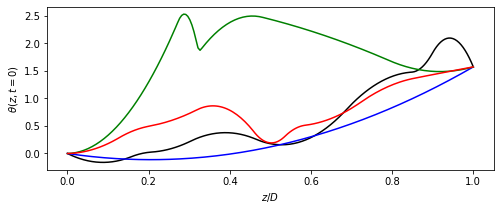

In [2]:
import matplotlib.pyplot as plt

N1=200

z=np.linspace(0,1,N1)
theta_0=random_function(N1,0,np.pi/2)
theta_1=random_function(N1,0,np.pi/2)
theta_2=random_function(N1,0,np.pi/2)
theta_3=random_function(N1,0,np.pi/2)


plt.figure(figsize=(8,3))
plt.plot(z,theta_0,'k-')
plt.plot(z,theta_1,'b-')
plt.plot(z,theta_2,'g-')
plt.plot(z,theta_3,'r-')
plt.xlabel('$z/D$')
plt.ylabel('$\\theta(z,t=0)$')
plt.show()



### Relaxational dynamics simulation
In nematic geometry with director $\mathbf n(z,t)=\left(\cos\theta(z,t),0,\sin\theta(z,t)\right)$, relaxational dynamics follows equations:
\begin{equation}
K_{33}\frac{\partial^2 n_x}{\partial z^2}=\gamma_1\frac{\partial n_x}{\partial t},
\end{equation}
\begin{equation}
K_{11}\frac{\partial^2 n_z}{\partial z^2}=\gamma_1\frac{\partial n_z}{\partial t},
\end{equation}
which are solved numerically using finite-difference method:

In [3]:
from numba import jit,njit, prange

@jit()
def THETAS(f,K1,K3,L,N,Nt=800000,save_every=800,dt=0.0000016,gamma=0.098):
    z=np.linspace(0,L,N)
    dz=z[1]-z[0]
    dz2=dz**2

    theta=f.copy()
    nx=np.cos(theta)
    nz=np.sin(theta)
    
    nx_new=nx.copy()
    nz_new=nz.copy()

    THETAS=np.zeros((Nt//save_every,N))
    for t in range(Nt):
        if t%save_every==0:
            theta=np.arctan2(nz,nx)
            THETAS[t//save_every,:]=theta

        nx_new[1:-1]=nx[1:-1]+dt/gamma*K3/dz2*(nx[2:]+nx[:-2]-2*nx[1:-1])
        nz_new[1:-1]=nz[1:-1]+dt/gamma*K1/dz2*(nz[2:]+nz[:-2]-2*nz[1:-1])
        nx[:]=nx_new/(nx_new**2+nz_new**2)**0.5
        nz[:]=nz_new/(nx_new**2+nz_new**2)**0.5
    return THETAS



Visualization of the relaxation from a random initial state of a liquid crystal with elastic constants $K_{11}=7\ \text{pN}$, $K_{33}=10\ \text{pN}$ and rotational viscosity $\gamma_1=0.089 \textrm{ Pa s}   $.

Shape of THETAS_1: (1000, 200)


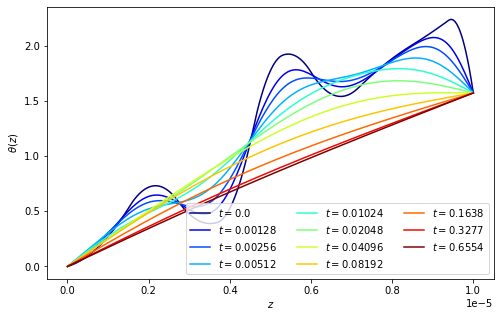

In [4]:
import matplotlib.cm as cm

N1=200                        # number of discertization points
L1=10*1e-6                    # cell thickness: L = 10um
z=np.linspace(0,L1,N1)
Nt=800000                     # number of time steps
save_every=800                # theta(z) is saved at every 'save_every'-th step
dt=0.0000016


theta_0=random_function(N1,0,np.pi/2)                # random initial function theta(z) with theta(0)=0 and theta(L1)=pi/2 boundary conditions
THETAS_1=THETAS(theta_0,7*1e-12,10*1e-12,L1,N1)      

print('Shape of THETAS_1:', THETAS_1.shape)

plt.figure(figsize=(8,5))
n=0
plt.plot(z,THETAS_1[n],color=cm.jet(0),label=f'$t={n*save_every*dt:.4}$')
n=1
plt.plot(z,THETAS_1[n],color=cm.jet(0.1),label=f'$t={n*save_every*dt:.4}$')
n=2
plt.plot(z,THETAS_1[n],color=cm.jet(0.2),label=f'$t={n*save_every*dt:.4}$')
n=4
plt.plot(z,THETAS_1[n],color=cm.jet(0.3),label=f'$t={n*save_every*dt:.4}$')
n=8
plt.plot(z,THETAS_1[n],color=cm.jet(0.4),label=f'$t={n*save_every*dt:.4}$')
n=16
plt.plot(z,THETAS_1[n],color=cm.jet(0.5),label=f'$t={n*save_every*dt:.4}$')
n=32
plt.plot(z,THETAS_1[n],color=cm.jet(0.6),label=f'$t={n*save_every*dt:.4}$')
n=64
plt.plot(z,THETAS_1[n],color=cm.jet(0.7),label=f'$t={n*save_every*dt:.4}$')
n=128
plt.plot(z,THETAS_1[n],color=cm.jet(0.8),label=f'$t={n*save_every*dt:.4}$')
n=256
plt.plot(z,THETAS_1[n],color=cm.jet(0.9),label=f'$t={n*save_every*dt:.4}$')
n=512
plt.plot(z,THETAS_1[n],color=cm.jet(1.0),label=f'$t={n*save_every*dt:.4}$')
plt.legend(ncol=3)
plt.xlabel('$z$')
plt.ylabel('$\\theta(z)$')
plt.show()



Simulation of light propagation through the reconfiguring liquid crystal between crossed polarizers. Function $\texttt{intensity}$ returns time dependent relative intensity (transmittance) $I(t)$.


In [5]:
@njit() 
def intensity(THETAS0,L,N,lbd_npy,w_npy,n_o0=1.545,n_e0=1.740):
	"""
	THETAS0 - theta(t,z) array of shape (Nt/save_every,N)
	L - nematic cell thickness
	N - number of discretization points along z
	lbd_npy, w_npy - numpy arrays describing the light intensity spectrum: wavelengths (lbd_npy) and spectrum values (w_npy)
	no0, ne0 - liquid crystal refractive indices
	"""
	intensities=np.zeros(len(THETAS0))
	n_o=n_o0
	h=L/(N-1)

	for k in range(len(intensities)):
		for l in range(len(lbd_npy)):
			lbd=lbd_npy[l]
			theta=THETAS0[k]
			THETA=(theta[1:]+theta[:-1])/2
			J0=1/(2**0.5) * np.array([1+0j,1+0j])
			dPHI=0.0
			for i in range(N-1):
				n_e=(1/((np.cos(THETA[i]))**2/n_e0**2+(np.sin(THETA[i]))**2/n_o0**2))**0.5
				dPHI=dPHI+(2*np.pi/lbd)*h*(n_e-n_o)

			J1=np.array([0+0j,0+0j])
			J1[0]=J0[0]
			J1[1]=J0[1]*np.e**((0+1j)*dPHI)

			J2=np.array([0+0j,0+0j])
			J2[0]=(0.5+0j)*(J1[0]-J1[1])
			J2[1]=(0.5+0j)*(-J1[0]+J1[1])

			intensities[k]=intensities[k]+w_npy[l]*((np.abs(J2[0]))**2+(np.abs(J2[1]))**2)
	return intensities




Diode spectrum. Saved at https://zenodo.org/record/7315598.

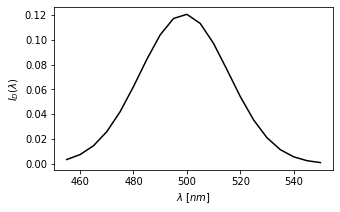

In [7]:
import pandas as pd

# https://zenodo.org/record/7315598/files/diode_lbd.csv?download=1

w_csv = pd.read_csv('https://zenodo.org/record/7315598/files/diode_w.csv?download=1')
lbd_csv = pd.read_csv('https://zenodo.org/record/7315598/files/diode_lbd.csv?download=1')
w_npy1=np.array(w_csv)[:,0]
lbd_npy1=np.array(lbd_csv)[:,0]

plt.figure(figsize=(5,3))
plt.plot(lbd_npy1/1e-9,w_npy1,'k-')
plt.xlabel('$\lambda$ $[nm]$' )
plt.ylabel('$I_D(\lambda)$' )
plt.show()

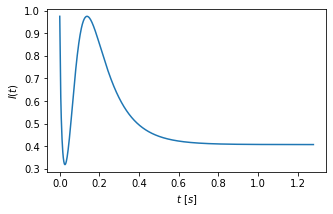

In [8]:
intensity_1=intensity(THETAS_1,L1,N1,lbd_npy1,w_npy1)


plt.figure(figsize=(5,3))
plt.plot(np.linspace(0,Nt*dt,Nt//save_every),intensity_1)
plt.xlabel('$t$ $[s]$')
plt.ylabel('$I(t)$')
plt.show()

Functions that create a training dataset with $\texttt{N_pairs}$ training pairs of shape $\mathbf X=[I(t=0),..., I(t=T)]$ and $\mathbf Y=[K_{11},K_{33}]$

In [9]:

@njit(parallel=True)
def makeK1K3(N_pairs,K_min=2,K_max=18):
	K1K3=np.zeros((N_pairs,2))
	for i in prange(len(K1K3)):
		K1K3[i,0]=np.random.uniform(K_min,K_max)*10**(-12)
		K1K3[i,1]=np.random.uniform(K_min,K_max)*10**(-12)
	return K1K3

def make_random_functions(N_pairs,N,AL=0,AR=np.pi/2):    
	random_functions=np.zeros((N_pairs,N))
	for i in prange(len(random_functions)):
		random_functions[i]=random_function(N,AL,AR)
	return random_functions
	

@njit(parallel=True)
def make_THETAS_all(random_functions,K1K3,L,N,Nt=800000,save_every=800):
	THETAS_all=np.zeros((len(random_functions),Nt//save_every,N))
	for i in prange(len(THETAS_all)):
		THETAS_all[i]=THETAS(random_functions[i],K1K3[i,0],K1K3[i,1],L,N)
	return THETAS_all


@njit(parallel=True)
def make_intensities_all(THETAS_all,L,N,lbd_npy,w_npy,Nt=800000,save_every=800):
	intensities_all=np.zeros((len(THETAS_all),Nt//save_every))
	for i in prange(len(intensities_all)):
		intensities_all[i]=intensity(THETAS_all[i],L,N,lbd_npy,w_npy)
	return intensities_all   

Example of use of functions $\texttt{makeK1K3}$, $\texttt{make_random_functions}$, $\texttt{make_THETAS_all}$, $\texttt{make_intensities_all}$ for creation of 10 training pairs:

In [10]:
N_pairs_0=10
L0=10*1e-6      # [m]
N0=200          # number of discretization points in z direction
w_csv = pd.read_csv('https://raw.githubusercontent.com/jakazaplotnik/Nematic-elastic-constants/main/diode_w.csv')
lbd_csv = pd.read_csv('https://raw.githubusercontent.com/jakazaplotnik/Nematic-elastic-constants/main/diode_lbd.csv')
w_npy1=np.array(w_csv)[:,0]
lbd_npy1=np.array(lbd_csv)[:,0]




K1K3_0=makeK1K3(N_pairs_0)
random_functions_0=make_random_functions(N_pairs_0,N0)
THETAS_0=make_THETAS_all(random_functions_0,K1K3_0,L0,N0)
intensities_0=make_intensities_all(THETAS_0,L0,N0,lbd_npy1,w_npy1)


Visualization of time-dependent intensities $I(t)$ corresponding to random initial states and various elastic constants $K_{11}$ and $K_{33}$:

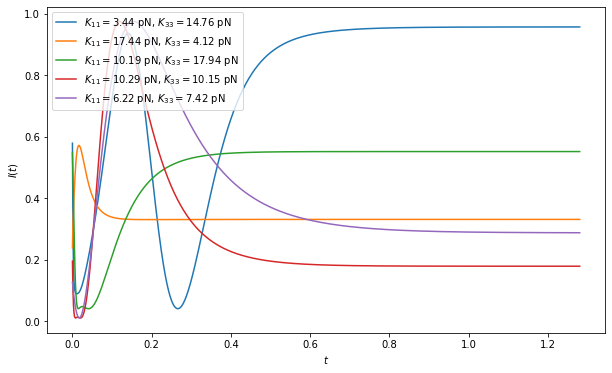

In [11]:
plt.figure(figsize=(10,6))
for n in range(5):
    plt.plot(np.linspace(0,Nt*dt,Nt//save_every),intensities_0[n],label=f'$K_{{11}}={K1K3_0[n,0]/1e-12:.2f}$ pN, $K_{{33}}={K1K3_0[n,1]/1e-12:.2f}$ pN')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$I(t)$')
plt.show()

Having more time and/or a supercomputer, one can build a training set with thousands of data pairs. This has been done, and 100,000 time-dependent intensities $I(t)$ labeled with corresponding elastic constants $K_{11}$ and $K_{33}$ can be found at [Zenodo](https://zenodo.org/record/7315524).



________________

Functions used for data normalization:

In [12]:
def norm(A,Kmin=2*1e-12,Kmax=18*1e-12):
    """normalization of the data in A where max(A)=Kmax [pN] and min(A)=Kmin [pN] to [0,1] interval"""
    shift=Kmin
    scale=Kmax-Kmin
    return (A-shift)/scale

def norm_inverse_to_pN(A,Kmin=2*1e-12,Kmax=18*1e-12):
    """inverse of norm(A,Kmin,Kmax)"""
    shift=Kmin/1e-12
    scale=(Kmax-Kmin)/1e-12
    return (A*scale+shift)

Each data packet of size (1000 $\times$ 1000) consists of $\texttt{packet_size}=1000$ time dependent intensities $I(t)$ and each $I(t)$ is saved in 1000 time steps on the [0 s, 1.28 s] interval. There are 100 such packets available at https://zenodo.org/record/7315524.


In [13]:
import csv
N_packets=100 
packet_size=1000


Y=np.zeros((N_packets*packet_size,2),dtype=np.float16)  # 2 constants
X=np.zeros((N_packets*packet_size,500),dtype=np.float16) # I(t) in 500 time steps
for i in range(N_packets):
    if i%10==0:
        print('Loading',i,'/',N_packets)
    X[i*packet_size:(i+1)*packet_size,:]=np.array(pd.read_csv(f'https://zenodo.org/record/7315598/files/intensities_{i}.csv?download=1',header=None))[:,::2]  # Resolution of 500 time steps is sufficient, therefore, every 2-nd data point is imported.
    Y[i*packet_size:(i+1)*packet_size,:]=norm(np.array(pd.read_csv(f'https://zenodo.org/record/7315598/files/K1K3_{i}.csv?download=1',header=None)))
print('Loading completed')


Loading 0 / 100
Loading 10 / 100
Loading 20 / 100
Loading 30 / 100
Loading 40 / 100
Loading 50 / 100
Loading 60 / 100
Loading 70 / 100
Loading 80 / 100
Loading 90 / 100
Loading completed


The data set is split into training data set (90,000 data pairs) and validation data set (10,000 data pairs):

In [14]:
N_valid=10000 # validation dataset size

X_train=X[:-N_valid]
X_test=X[-N_valid:]

Y_train=Y[:-N_valid]
Y_test=Y[-N_valid:]


print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)



(90000, 500) (90000, 2)
(10000, 500) (10000, 2)


Random example from the training data set. $I(t)$ is discretized in 500 time-steps written in a 500-dimensional input vector $\mathbf X$. The output vector $\mathbf Y$ is a 2-dimensional vector containing $K_{11}$ and $K_{33}$. Intensities are already normalized to [0,1] interval, while elastic constants are nomralized manually using function $\texttt{norm()}$

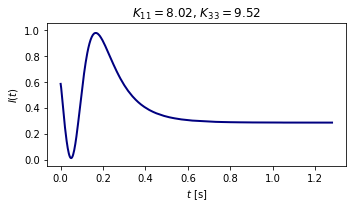

In [28]:
#@title
N=np.random.randint(0,500)

plt.figure(figsize=(5,3))
plt.plot(np.linspace(0,1.28,500),X_train[N],color='navy',linewidth=2)
plt.ylabel('$I(t)$')
plt.xlabel('$t$ [s]')
plt.title(f'$K_{{11}}={norm_inverse_to_pN(Y_train[N])[0]:.2f}$, $K_{{33}}={norm_inverse_to_pN(Y_train[N])[1]:.2f}$') #constants [K11,K33] v pN
plt.ylim(-0.05,1.05)
plt.tight_layout()
plt.show()

In [16]:
import tensorflow as tf
print("TensorFlow version ",tf.__version__)
from tensorflow import keras
print ("Keras version ",keras.__version__)

TensorFlow version  2.9.2
Keras version  2.9.0


## Construction and training of a neural network
Input layer size = **500**
1st hidden layer size = **500**, 1st hidden layer activation function: **ReLU**

2nd hidden layer size = **400**, 2nd hidden layer activation function: **ReLU**

3rd hidden layer size = **200**, 3rd hidden layer activation function: **ReLU**

4th hidden layer size = **100**, 4th hidden layer activation function: **ReLU**

Output layer = **2**, output activation function: **Sigmoid**

Loss function: **Mean absolute error**

Optimizer: **Adam**

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout


opt = optimizers.Adam(learning_rate=0.002)
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1,mode='auto',min_delta=0.00001, cooldown=0, min_lr=0,)
model = Sequential()
model.add(Dense(500,activation='relu',input_shape=(500,)))

model.add(Dense(400,activation='relu'))

model.add(Dense(200,activation='relu'))

model.add(Dense(100,activation='relu'))

model.add(Dense(2,activation='sigmoid'))


model.compile(optimizer=opt, loss="mean_absolute_error")



history=model.fit(X_train[:],Y_train[:],epochs=10,batch_size=30,validation_data=(X_test,Y_test),shuffle=True,callbacks=[reduce_lr])




Epoch 1/10
3000/3000 [==============================] - 28s 9ms/step - loss: 0.1165 - val_loss: 0.0962 - lr: 0.0020
Epoch 2/10
3000/3000 [==============================] - 25s 8ms/step - loss: 0.0938 - val_loss: 0.0888 - lr: 0.0020
Epoch 3/10
3000/3000 [==============================] - 27s 9ms/step - loss: 0.0886 - val_loss: 0.0847 - lr: 0.0020
Epoch 4/10
3000/3000 [==============================] - 24s 8ms/step - loss: 0.0858 - val_loss: 0.0908 - lr: 0.0020
Epoch 5/10
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0834 - val_loss: 0.0870 - lr: 0.0020
Epoch 6/10
3000/3000 [==============================] - 27s 9ms/step - loss: 0.0817 - val_loss: 0.0823 - lr: 0.0020
Epoch 7/10
3000/3000 [==============================] - 31s 10ms/step - loss: 0.0787 - val_loss: 0.0757 - lr: 0.0020
Epoch 8/10
3000/3000 [==============================] - 31s 10ms/step - loss: 0.0776 - val_loss: 0.0774 - lr: 0.0020
Epoch 9/10
3000/3000 [==============================] - 31s 10ms/step

#### Training history

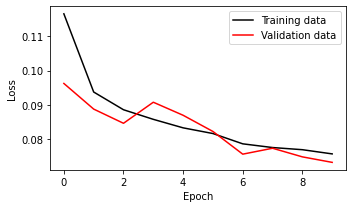

In [18]:
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'],'k-',label='Training data')
plt.plot(np.array(history.history['val_loss']),'r-', label='Validation data')
val=history.history['val_loss']
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

## Neural network validation
The performance of the trained neural network is validated on validation data that was not used for training. Here we compare predicted and expected outputs for the inputs from the validation set:

313/313 [==============================] - 1s 4ms/step


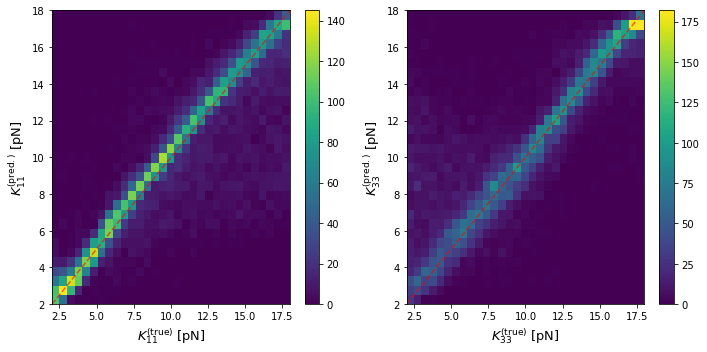

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist2d(norm_inverse_to_pN(Y_test[:,0]),norm_inverse_to_pN(model.predict(X_test)[:,0]),bins=31,range=[[2,18],[2,18]])
plt.xlabel('$K_{11}^{\mathrm{(true)}}$ [pN]',fontsize=13)
plt.ylabel('$K_{11}^{\mathrm{(pred.)}}$ [pN]',fontsize=13)
plt.plot([2,18],[2,18],'r--',alpha=0.6)
plt.colorbar()

plt.subplot(122)
plt.hist2d(norm_inverse_to_pN(Y_test[:,1]),norm_inverse_to_pN(model.predict(X_test)[:,1]),bins=31,range=[[2,18],[2,18]])
plt.xlabel('$K_{33}^{\mathrm{(true)}}$ [pN]',fontsize=13)
plt.ylabel('$K_{33}^{\mathrm{(pred.)}}$ [pN]',fontsize=13)
plt.plot([2,18],[2,18],'r--',alpha=0.6)
plt.colorbar()
plt.tight_layout()
plt.show()

## Determination of elastic constants of the 5CB nematic liquid crystal from experimentally measured $I(t)$ using the neural network that was trained on numerical simulations.



Import and visualization of experimental data. At times $ t < 0$, random electric pulses are applied to the LC sample to impose deformations because of which the director reconfigures back to its minimum free energy state at times $t > 0$.

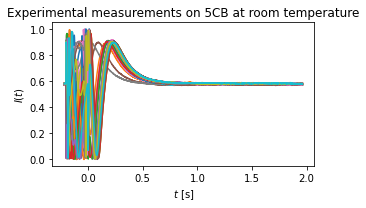

In [20]:
n_measurements=30 #30 eksperimentalnih setov meritev
exp_time_steps=17440 #merjeno v 17440 casovnih tockah

time_raw=np.zeros((n_measurements,exp_time_steps))
INTENSITIES_raw=np.zeros((n_measurements,exp_time_steps))


for i in range(n_measurements):
    time_raw[i,:]=np.array(pd.read_csv(f'https://raw.githubusercontent.com/jakazaplotnik/Nematic-elastic-constants/main/Experimental_data/experimental_time_{i}.csv',header=None))[:,0]
    INTENSITIES_raw[i,:]=np.array(pd.read_csv(f'https://raw.githubusercontent.com/jakazaplotnik/Nematic-elastic-constants/main/Experimental_data/experimental_intensity_{i}.csv',header=None))[:,0]
    
    
plt.figure(figsize=(5,3))
plt.title('Experimental measurements on 5CB at room temperature')
plt.ylabel('$I(t)$')
plt.xlabel('$t$ [s]')
for i in range(n_measurements):
    plt.plot(time_raw[i],INTENSITIES_raw[i])
plt.tight_layout()
plt.show()



To determine elastic constants from experiemntally measured intensities, $I(t)$ shold be presented in the same vector format as numerical data. Therefore, we crop $I(t)$ function to the $[0,T]$ interval, where $T=\texttt{dt}*\texttt{Nt}=1.28\ s$ for parameters $\texttt{dt}$ and $\texttt{Nt}$ used in previous cells of this notebook and interpolate the values to 500 equidistant calculation points in time domain.

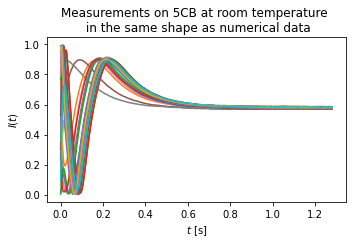

In [21]:
t_interp=np.linspace(0,1.28,500)
INTENSITIES=np.zeros((n_measurements,500))
TIMEs=np.zeros((n_measurements,500))

for i in range(n_measurements):
    f=interp1d(time_raw[i,::10],INTENSITIES_raw[i,::10],kind='quadratic') 
    TIMEs[i,:]=t_interp
    INTENSITIES[i,:]=f(t_interp)

plt.figure(figsize=(5,3.5))
plt.title('Measurements on 5CB at room temperature \n in the same shape as numerical data')
plt.ylabel('$I(t)$')
plt.xlabel('$t$ [s]')
for i in range(n_measurements):
    plt.plot(TIMEs[i],INTENSITIES[i])
plt.tight_layout()
plt.show()
    


#### Neural network predictions of elastic constants from experimentally measured time dependent intensities $I(t)$

In [22]:
RESULTS=norm_inverse_to_pN(model.predict(INTENSITIES))

MEAN=np.mean(RESULTS,axis=0)
STD=np.std(RESULTS,axis=0)
print(RESULTS)
print('-------------------------')
print('K11=',MEAN[0],'+-',STD[0])
print('K33=',MEAN[1],'+-',STD[1])


1/1 [==============================] - 0s 58ms/step
[[ 8.48831    7.3215475]
 [ 6.463908   9.730356 ]
 [ 6.52242    9.341003 ]
 [ 6.749537   9.202499 ]
 [ 6.6164265  9.089744 ]
 [ 6.198129  10.013128 ]
 [ 5.7615247  9.672081 ]
 [ 5.961031   9.245137 ]
 [ 6.5320215  9.174194 ]
 [ 6.559964   8.931528 ]
 [ 6.0711207  9.393172 ]
 [ 7.207902   9.331349 ]
 [ 7.174665   9.291189 ]
 [ 7.2255154  9.302805 ]
 [ 6.7565074  9.153139 ]
 [ 6.878531   9.137174 ]
 [ 6.5724044  8.940147 ]
 [ 5.9919767  9.324095 ]
 [ 6.9801273  9.061542 ]
 [ 6.7109165  9.207979 ]
 [ 6.583576   9.177332 ]
 [ 6.3604097  9.402981 ]
 [ 6.1699204  9.220834 ]
 [ 5.605449   9.6378   ]
 [ 6.206153   9.509392 ]
 [ 6.6303153  9.084015 ]
 [ 6.496414   9.037451 ]
 [ 6.392799   8.917166 ]
 [ 6.3674064  9.177389 ]
 [ 6.7754164  9.202988 ]]
-------------------------
K11= 6.567026 +- 0.52870125
K33= 9.207706 +- 0.42546558


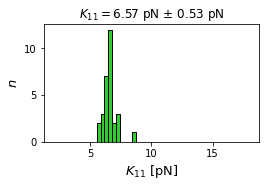

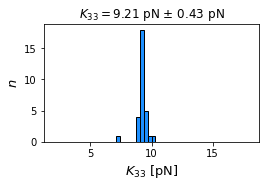

In [23]:
plt.figure(figsize=(3.8,2.7))
plt.hist(RESULTS[:,0],range=(2,18),bins=50,color='limegreen',edgecolor='k')
plt.xlabel('$K_{11}$ [pN]',fontsize=13)
plt.ylabel('$n$',fontsize=13)


plt.title("$K_{{11}}={0:.2f}$ pN $ \pm\ {1:.2f}$ pN".format(MEAN[0],STD[0]))

plt.tight_layout()
plt.show()

plt.figure(figsize=(3.8,2.7))
plt.xlabel('$K_{33}$ [pN]',fontsize=13)
plt.ylabel('$n$',fontsize=13)
plt.hist(RESULTS[:,1],range=(2,18),bins=50,color='dodgerblue',edgecolor='k')
plt.title("$K_{{33}}={0:.2f}$ pN $ \pm\ {1:.2f}$ pN".format(MEAN[1],STD[1]))

plt.tight_layout()
plt.show()